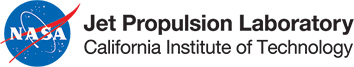

# **Delta-X Workshop**

## **Module 3: Accoustic Doppler Current Profiler:**
*Created by Alexandra Christensen (April 2022)*

*Jet Propulsion Laboratory, California Institute of Technology*

*© 2022 California Institute of Technology. Government sponsorship acknowledged.*

Data Access:

>Search ORNL DAAC for Delta-X ADCP

>https://daac.ornl.gov/cgi-bin/dsviewer.pl?ds_id=2081

Data Citations:

> Christensen, A.L., J.M. Mallard, J. Nghiem, M. Simard, T.M. Pavelsky, and M.P. Lamb. 2022. Delta-X: Acoustic Doppler Current Profiler Channel Surveys, MRD, Louisiana, 2021. ORNL DAAC, Oak Ridge, Tennessee, USA. https://doi.org/10.3334/ORNLDAAC/2081



Authors:

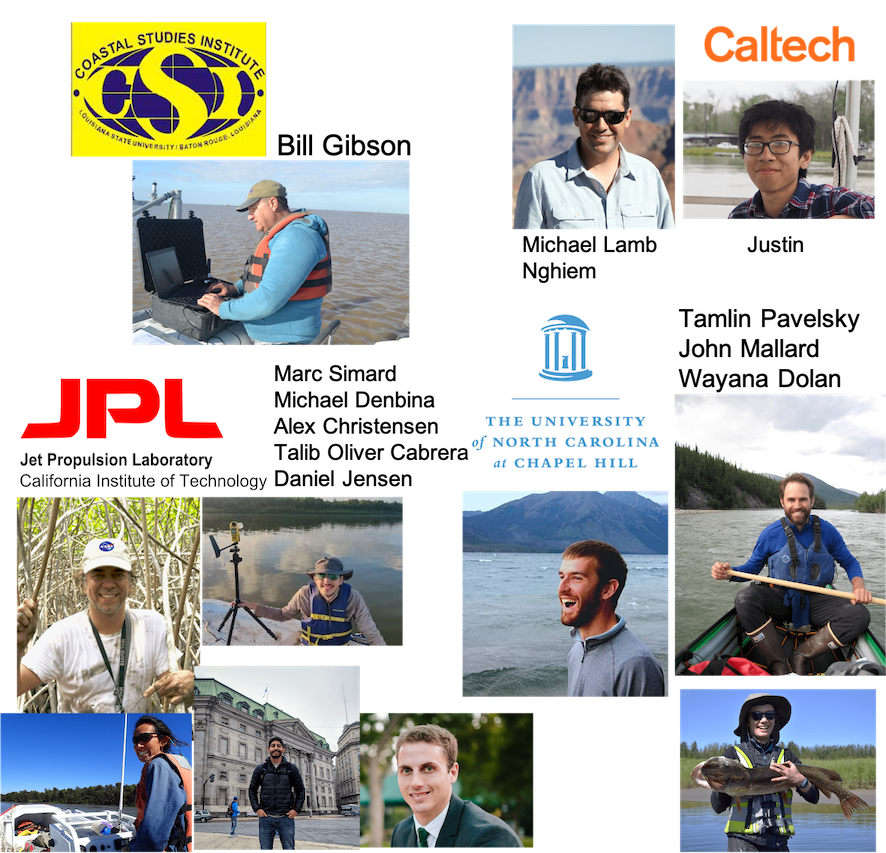


# ADCPs are used to measure discharge within a channel using velocity profiles along a transect perpendicular to flow. 

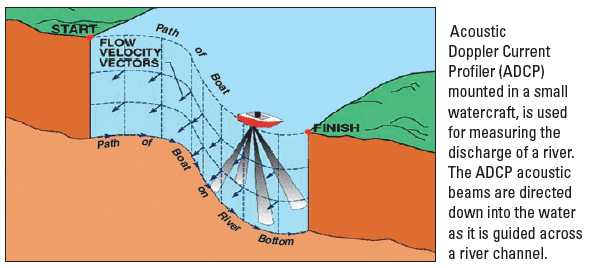

First, we will import necessary packages.

If you're using Google Colab, you'll need to pip install a few packages and grant access to your Google Drive. 


In [1]:
!pip install rasterio
import rasterio
import rasterio.plot

from osgeo import gdal
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import string

input_dir = os.getcwd()
print(input_dir)

     |████████████████████████████████| 19.3 MB 59.3 MB/s 
/content


**If you are not using Google Colab, don't run the next cell. It will change your input directory to the shared Google Drive folder, which you should only do if you're using Google Colab**

Second, we will grant access to your Google Drive account. If you have not done this before (or it's been a while), you will need to approve access. There will be 2 popups, make sure to allow both.

In [3]:
#For access to Google Drive files
from google.colab import files
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

#For saving to Google Drive
from google.colab import drive

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
Gdrive = GoogleDrive(gauth)

drive.mount('/content/drive',force_remount=True)
input_dir = '/content/drive/My Drive/DeltaX_Workshop_2022/Tutorials/0_Field/Module3_ADCP'


Mounted at /content/drive


We will load a basemap file so we can make some maps. This basemap a digital elevation model (DEM) based on USGS lidar and pre-DeltaX bathymetry.

In [4]:
basemap = rasterio.open(input_dir + '/basemap.tif')


Open the ADCP summary file and print the first few lines to get an idea of what the data look like.

In [5]:
summary_file = pd.read_csv(input_dir + "/DeltaX_ADCP_Measurements_V2_2081/data/DeltaX_RiverDischarge_Spring2021.csv")

summary_file = summary_file.astype({'planned_latitude':'float','planned_longitude':'float','discharge_total':'float'})

summary_file.head()

,profiler_id,team,basin,campaign,filename,transect,location,site_name,replicate,planned_latitude,...,boat_speed,mean_speed,discharge_side,discharge_top,discharge_middle,discharge_bottom,discharge_total,flow_direction,notes,mount_type
0,Teledyne RiverPro,CSI,Atchafalaya,Spring 2021,ADCP_20210326-091705_ATCH-ICWW_ICWW-A_000_Rep1...,0,ATCH-ICWW,ICWW-A,1,29.644505,...,0.94,0.51,2.22,46.27,338.36,43.01,429.86,284.38,"DGPS was not activated, bottomt tracking was u...",Boat bow
1,Teledyne RiverPro,CSI,Atchafalaya,Spring 2021,ADCP_20210326-091705_ATCH-ICWW_ICWW-A_000_Rep2...,0,ATCH-ICWW,ICWW-A,2,29.644505,...,0.86,0.54,5.65,43.49,324.22,42.86,416.22,286.02,"DGPS was not activated, bottomt tracking was u...",Boat bow
2,Teledyne RiverPro,CSI,Atchafalaya,Spring 2021,ADCP_20210326-095611_ATCH-ICWW_ICWW-A_001_Rep1...,1,ATCH-ICWW,ICWW-A,1,29.644505,...,1.37,0.52,1.89,45.62,329.32,43.42,420.25,282.66,"DGPS was not activated, bottomt tracking was u...",Boat bow
3,Teledyne RiverPro,CSI,Atchafalaya,Spring 2021,ADCP_20210326-095611_ATCH-ICWW_ICWW-A_001_Rep2...,1,ATCH-ICWW,ICWW-A,2,29.644505,...,1.25,0.50,3.05,43.69,317.87,42.42,407.02,287.21,"DGPS was not activated, bottomt tracking was u...",Boat bow
4,Teledyne RiverPro,CSI,Atchafalaya,Spring 2021,ADCP_20210326-100220_ATCH-ICWW_ICWW-B_002_Rep1...,2,ATCH-ICWW,ICWW-B,1,29.640151,...,0.90,0.56,2.08,41.82,360.92,45.77,450.59,263.08,"DGPS was not activated, bottomt tracking was u...",Boat bow


We will start by finding the average discharge at each site location and mapping them on top of our basemap.


In [6]:
discharge_means = summary_file.groupby(['site_name'])[['planned_longitude','planned_latitude','discharge_total']].agg(np.nanmean).reset_index()



Then we plot these averages on top of the basemap.

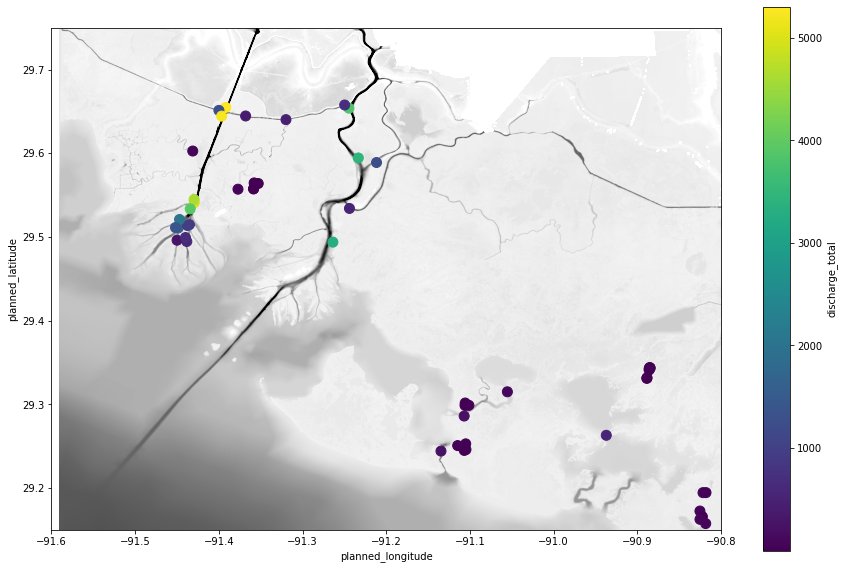

In [7]:
fig, ax = plt.subplots(figsize=(15,10))
rasterio.plot.show(basemap,transform=basemap.transform,vmin=-10,vmax=2,ax=ax,cmap='Greys_r')
plt.axis([-91.6, -90.8, 29.15, 29.75])

discharge_means.plot(x="planned_longitude", y="planned_latitude",ax=ax,kind="scatter",s=100,c="discharge_total",cmap="viridis")


ADCP measurements along a channel are often uesd to estimate exchange between channels and adjacent floodplains. If two transects are measured simultaneously (or close together in time), the difference in flow (m3/s) represents flux into or out of the channel. 

Next, we will compare discharge value along one channel, the Wax Lake Outlet, from upstream to downstream.

We filter the data to include only transects WLO-A, C, D, and E. 



In [8]:
WLO = summary_file[summary_file['site_name'].str.contains('|'.join(['WLO-A','WLO-C','WLO-D','WLO-E']))]



Then we compare average discharge values for these transects throughout the entire field campaign

                  mean         std
site_name                         
WLO-A      5300.569167   91.090140
WLO-C      5228.963125  200.776176
WLO-D      4628.926875  217.915005
WLO-E      3918.138750  195.946293


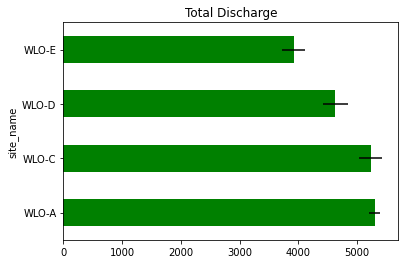

In [9]:
qual = WLO.groupby(['site_name'])['discharge_total'].agg([np.mean, np.std])
qual.plot(kind = "barh", y = "mean", legend = False,
          xerr = "std", title = "Total Discharge", color='green', ylabel='Total Discharge (m3/s)')
print(qual)

Hydrology in the Wax Lake Delta is strongly influenced by discharge in the Wax Lake Outlet and Atchafalaya River. However, tides can also impact discharge in this channel. These transects were collected within a week of each other and discharge values can vary by +/-200m3/s. Some of this is variation from instrument and collection methods, but some is due to changes in discharge at different tidal stages.

If you want to explore how discharge varies, we need to subset the data by date and time to isolate one particular time period.

You can check offshore tides from the NOAA Amerada Pass tide gauge:



> https://tidesandcurrents.noaa.gov/waterlevels.html?id=8764227&units=metric&bdate=20210325&edate=20210401&timezone=LST/LDT&datum=NAVD&interval=6&action=




We will look at an example from high tide on 3/26/2021 between 1:30 and 3pm. 

               mean         std
site_name                      
WLO-A      5257.715   95.890751
WLO-C      5233.285   12.310729
WLO-D      5072.625  107.063038
WLO-E      4201.330    8.188297


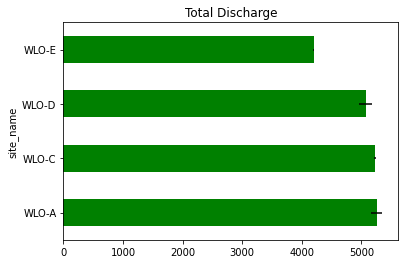

In [10]:
WLO_0327 = WLO[(pd.to_datetime(WLO['start_date'].astype('string') + " " +WLO['start_time'])<'03-27-2021 15:30:00')]
qual = WLO_0327.groupby(['site_name'])['discharge_total'].agg([np.mean, np.std])
qual.plot(kind = "barh", y = "mean", legend = False,
          xerr = "std", title = "Total Discharge", color='green', ylabel='Total Discharge (m3/s)')
print(qual)

Since these transects were taken around the same time, differences between discharge values could indicate fluxes in and out of the Wax Lake Outlet.

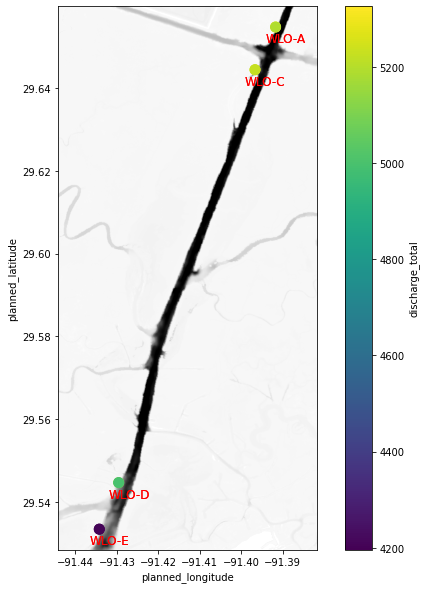

In [11]:
xmin = np.min(WLO_0327['planned_longitude'])
ymin = np.min(WLO_0327['planned_latitude'])
xmax = np.max(WLO_0327['planned_longitude'])
ymax = np.max(WLO_0327['planned_latitude'])

fig, ax = plt.subplots(figsize=(10,10))
rasterio.plot.show(basemap,transform=basemap.transform,vmin=-20,vmax=2,ax=ax,cmap='Greys_r')
plt.axis([xmin-0.01, xmax+0.01, ymin-0.005, ymax+0.005])
WLO_0327.plot(x="planned_longitude", y="planned_latitude",s=100, ax=ax,c = 'discharge_total',kind="scatter",cmap = 'viridis')

for k, v in WLO_0327.iterrows():
    ax.annotate(v['site_name'],[v['planned_longitude'],v['planned_latitude']],
               xytext=(-10,-15), textcoords='offset points',
               family='sans-serif', fontsize=12, color='red')

There is a slight decrease in discharge from upstream to downstream, indicating exchange between the outlet and side channels or marshes. 

A few things to notice:


*   You'll notice there is very little difference between WLO-A and WLO-C despite being on opposite sides of the Intracoastal Wateway. This suggests very little flow from the Wax Lake Outlet exits through the ICWW and vice versa.
*   The decrease in discharge betweewn WLO-D and WLO-E is ~750m3/s, which suggests the discharge through Crewboat Channel is 750m3/s.






We can do something similar in Terrebonne, where discharges are much smaller.

Let's first subset data to only CRMS 0421 and plot the location of these transects.

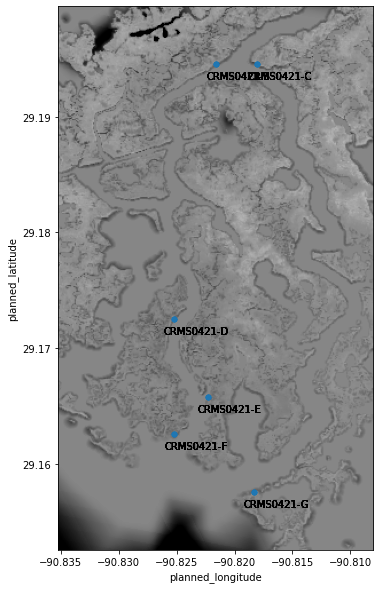

In [12]:
CRMS0421 = summary_file[summary_file['site_name'].str.contains('CRMS0421')]

xmin = np.min(CRMS0421['planned_longitude'])
ymin = np.min(CRMS0421['planned_latitude'])
xmax = np.max(CRMS0421['planned_longitude'])
ymax = np.max(CRMS0421['planned_latitude'])

fig, ax = plt.subplots(figsize=(10,10))
rasterio.plot.show(basemap,transform=basemap.transform,vmin=-1,vmax=2,ax=ax,cmap='Greys_r')
plt.axis([xmin-0.01, xmax+0.01, ymin-0.005, ymax+0.005])
import string
CRMS0421.plot(x="planned_longitude", y="planned_latitude", ax=ax,kind="scatter")

for k, v in CRMS0421.iterrows():
    ax.annotate(v['site_name'],[v['planned_longitude'],v['planned_latitude']],
               xytext=(-10,-15), textcoords='offset points',
               family='sans-serif', fontsize=10, color='black')

We can average discharge values for the entire field campaign to see variation in channel flow.

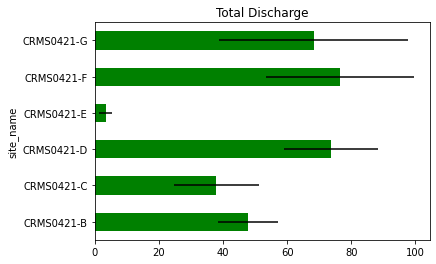

In [13]:
qual = CRMS0421.groupby(['site_name'])['discharge_total'].agg([np.mean, np.std])

qual.plot(kind = "barh", y = "mean", legend = False,
          xerr = "std", title = "Total Discharge", color='green', ylabel='Total Discharge (m3/s)')

If we look at a particular collection period, where transects are measured within the same time period, we can compare discharge values along a channel to estimate flow of water through the marshes. 

We will look at samples from 4/6/21 around 3pm


In [14]:
CRMS0421_first = CRMS0421[pd.to_datetime(CRMS0421['start_date'].astype('string') + " " +CRMS0421['start_time'])<'04-06-2021 16:00:00']


And we'll find the average of each transect.

In [15]:
CRMS0421_first.groupby(['site_name'])['discharge_total'].mean()


site_name
CRMS0421-B    33.2880
CRMS0421-C    19.5755
CRMS0421-D    69.5555
CRMS0421-E     3.4100
CRMS0421-F    83.9720
CRMS0421-G    85.0510
Name: discharge_total, dtype: float64

Then we can plot these discharge values on our basemap

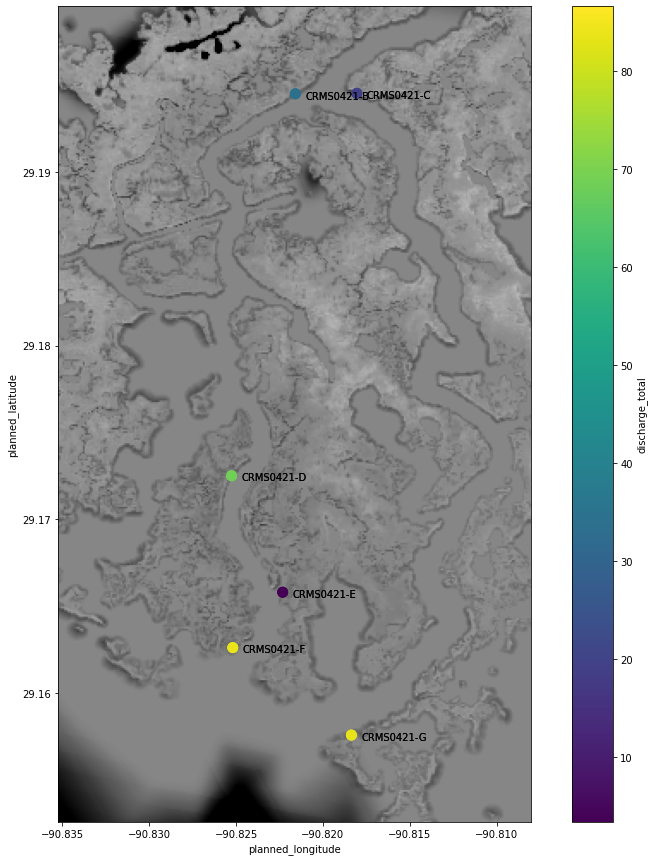

In [16]:
fig, ax = plt.subplots(figsize=(15,15))
rasterio.plot.show(basemap,transform=basemap.transform,vmin=-1,vmax=2,ax=ax,cmap='Greys_r')
plt.axis([xmin-0.01, xmax+0.01, ymin-0.005, ymax+0.005])
import string
CRMS0421_first.plot(x="planned_longitude", y="planned_latitude",ax=ax,kind="scatter",s=100,c="discharge_total",cmap="viridis")

for k, v in CRMS0421_first.iterrows():
    ax.annotate(v['site_name'],[v['planned_longitude'],v['planned_latitude']],
               xytext=(10,-5), textcoords='offset points',
               family='sans-serif', fontsize=10, color='black')

Transect B, D, and F occur along the same channel. Changes in discharge from upstream to downstream would indicate flow into or out of the adjacent marshes or small channels. 
Flow goes from 33 m3/s at transect B, to 70 m3/s at transect D, to 85 m3/s at transect F. 

At this time, the tide is rising, meaning water is most likely flowing north. Therefore, this could indicate that 15m3/s moves from channels to marshes between transect F and transect D and 36 m3/s moves from channels to marshes between transect D and B.

See drawing below for an idea of what this could indicate.




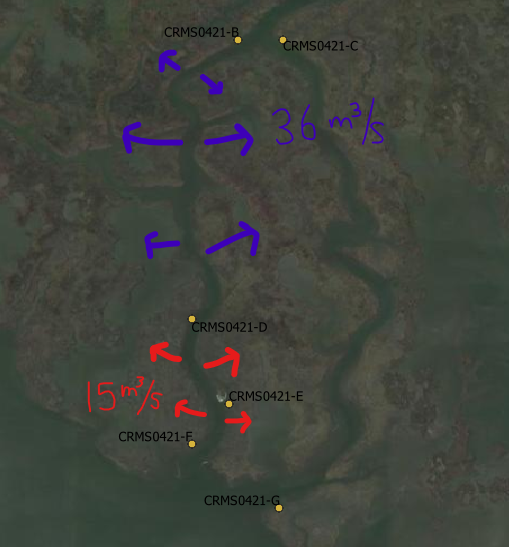

# For the last part of this module, we will look at channel cross-section shape

In addition to discharge data, the ADCP dataset also includes channel cross-section data. For the spring dataset, each transect comes with an individual files that contain river depth measurements across the entire transect.


We will compare two different channel cross-sections: WLO-A and WLO-Fan_C


In [17]:
WLOA = pd.read_csv(input_dir + "/DeltaX_ADCP_Measurements_V2_2081/data/ADCP_20210327-174128_WLO_WLO-A_010_Rep1_Bathy.csv")
WLOFanC = pd.read_csv(input_dir + "/DeltaX_ADCP_Measurements_V2_2081/data/ADCP_20210327-195927_WLO_WLO-Fan-C_017_Rep1_Bathy.csv")

WLOA.head()

,ensemble,date,time,distance_traveled,river_depth,latitude,longitude,bin_width
0,19,20210327,17:41:28,0.00,2.65,29.654580,-91.391646,NAN
1,20,20210327,17:41:29,0.04,2.64,29.654578,-91.391640,NAN
2,21,20210327,17:41:29,0.08,2.64,29.654578,-91.391640,NAN
3,22,20210327,17:41:30,0.11,2.66,29.654575,-91.391635,NAN
4,23,20210327,17:41:31,0.17,2.65,29.654571,-91.391630,NAN


We plot these channel shapes using distance traveled (m) and river depth (m). These depth values are not absolute, meaning that are not relative to a vertical datum.

In [ ]:
fig,[[ax1,ax1b],[ax2,ax2b]] = plt.subplots(nrows=2,ncols=2,figsize = (20,15))

WLOA.plot(x="distance_traveled", y="river_depth",ax=ax1,kind="line",c='blue')
ax1.set_ylim(ax1.get_ylim()[::-1])
ax1.legend(['WLO-A'])

rasterio.plot.show(basemap,transform=basemap.transform,vmin=-10,vmax=2,ax=ax1b,cmap='Greys_r')
ax1b.axis([-91.5,-91.35,29.4,29.66])
summary_file[summary_file['site_name']=='WLO-A'].plot(x="planned_longitude", y="planned_latitude",ax=ax1b,kind="scatter",s=50,c="blue")

WLOFanC.plot(x="distance_traveled", y="river_depth",ax=ax2,kind="line",c='orange')
ax2.set_ylim(ax2.get_ylim()[::-1])
ax2.legend(['WLO-Fan-C'])

rasterio.plot.show(basemap,transform=basemap.transform,vmin=-10,vmax=2,ax=ax2b,cmap='Greys_r')
ax2b.axis([-91.5,-91.35,29.4,29.66])
summary_file[summary_file['site_name']=='WLO-Fan-C'].plot(x="planned_longitude", y="planned_latitude",ax=ax2b,kind="scatter",s=50,c="orange")







Notice how different channel shapes are when comparing the main channel (WLO-A) and the deltaic channels (WLO-Fan-C). You can explore these further by importing different channels. You'll notice that shapes very greatly between Atchafalaya and Terrebonne and between tidal and river dominated areas.

Future datasets will also include velocity profiles of each transect. You'll be able to find those in the ORNL archive in the next few months.